# **Step 1: Import Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 2: Load Data**

In [ ]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [ ]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# **Step 3: Exploratory Data Analysis**

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')

print(f'Average number of ratings per movie: {n_ratings/n_movies}')
print(f'Average number of ratings per user: {n_ratings/n_users}')

Number of ratings: 100836
Number of movies: 9724
Number of users: 610
Average number of ratings per movie: 10.369806663924312
Average number of ratings per user: 165.30491803278687


## **Distribution of Movie Ratings**

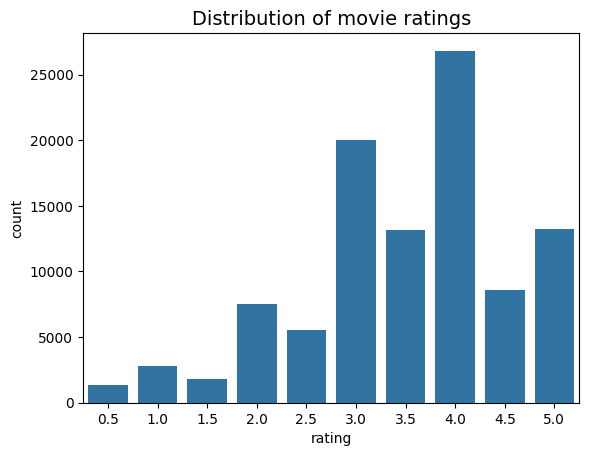

In [ ]:
sns.countplot(x = 'rating', data = ratings)
plt.title("Distribution of movie ratings", fontsize = 14)
plt.show()

In [ ]:
# Mean global Rating
print(f"Mean global rating: {round(ratings['rating'].mean(), 2)}")

Mean global rating: 3.5


In [ ]:
# mean ratings per user
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}")

Mean rating per user: 3.66


## **Movies which are rated frequently**

In [ ]:
ratings['movieId'].value_counts()

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
86279,1
86922,1
5962,1


In [ ]:
# Merging the ratings and movies dataframes on the basis of movieid
movie_ratings = ratings.merge(movies, on = 'movieId')
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


## **Highest and lowest rated  movies**

In [ ]:
# Mean ratings of all the movies
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
mean_ratings.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [ ]:
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [ ]:
ratings[ratings['movieId'] == highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


## **Bayesian Average**

In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


In [ ]:
# Average number of ratings for each movies and their average rating
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings: {C:.2f}")
print(f"Average rating: {m:.2f}")

Average number of ratings: 10.37
Average rating: 3.26


In [ ]:
def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C + ratings.count())
    return round(bayesian_avg, 3)

In [ ]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

In [ ]:
# Obtaining the bayesian average ratings of all the movies
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on = 'movieId') # Merge the baysian average with movie stats df

In [ ]:
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [ ]:
# Merging the movie title to movie stats df
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending = False)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)


## **A Glimpse at Movie Genres**

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [ ]:
# Finding the number of movies belonging to each genres
from collections import Counter

genre_frequency =  Counter(g for genres in movies['genres'] for g in genres)
print(f'There are {len(genre_frequency)} genres.')
genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [ ]:
print(f'The most common genre is \n {genre_frequency.most_common(5)}')

The most common genre is 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


                 genre  frequency
0            Adventure       1263
1            Animation        611
2             Children        664
3               Comedy       3756
4              Fantasy        779
5              Romance       1596
6                Drama       4361
7               Action       1828
8                Crime       1199
9             Thriller       1894
10              Horror        978
11             Mystery        573
12              Sci-Fi        980
13                 War        382
14             Musical        334
15         Documentary        440
16                IMAX        158
17             Western        167
18           Film-Noir         87
19  (no genres listed)         34


<ipython-input-27-3fb8c996496d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'genre', y = 'frequency',


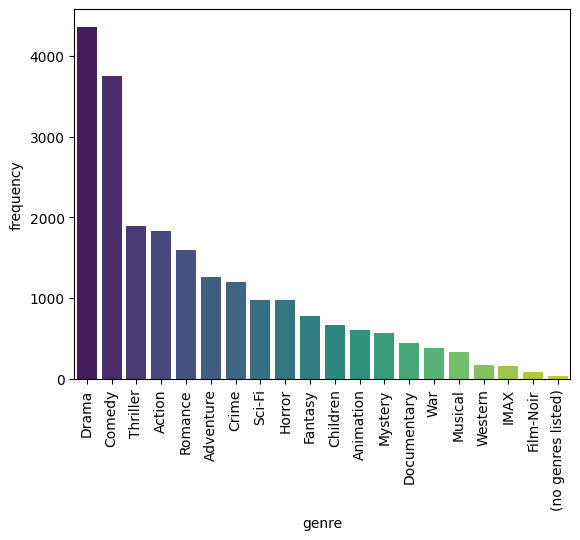

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).transpose().reset_index()
genre_frequency_df.columns = ['genre', 'frequency']
print(genre_frequency_df)

sns.barplot(x = 'genre', y = 'frequency',
            data = genre_frequency_df.sort_values(by = 'frequency', ascending = False),
            palette='viridis')
plt.xticks(rotation = 90)
plt.show()

# **Step 4: Data Pre-Processing**

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df['rating'], (user_index, item_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [ ]:
X.shape

(610, 9724)

In [ ]:
print(user_mapper)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 12

## **Evaluating sparsity**

In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)} %")

Matrix sparsity: 1.7 %


In [ ]:
n_ratings_per_user = X.getnnz(axis = 1)
len(n_ratings_per_user)

610

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [ ]:
n_ratings_per_movie = X.getnnz(axis = 0)
len(n_ratings_per_movie)

9724

In [ ]:
print(f"Most rated movie has {n_ratings_per_movie.max()} users.")
print(f"Least rated movie has {n_ratings_per_movie.min()} users.")

Most rated movie has 329 users.
Least rated movie has 1 users.


In [ ]:
X

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

<ipython-input-37-44089890dcd7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
<ipython-input-37-44089890dcd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


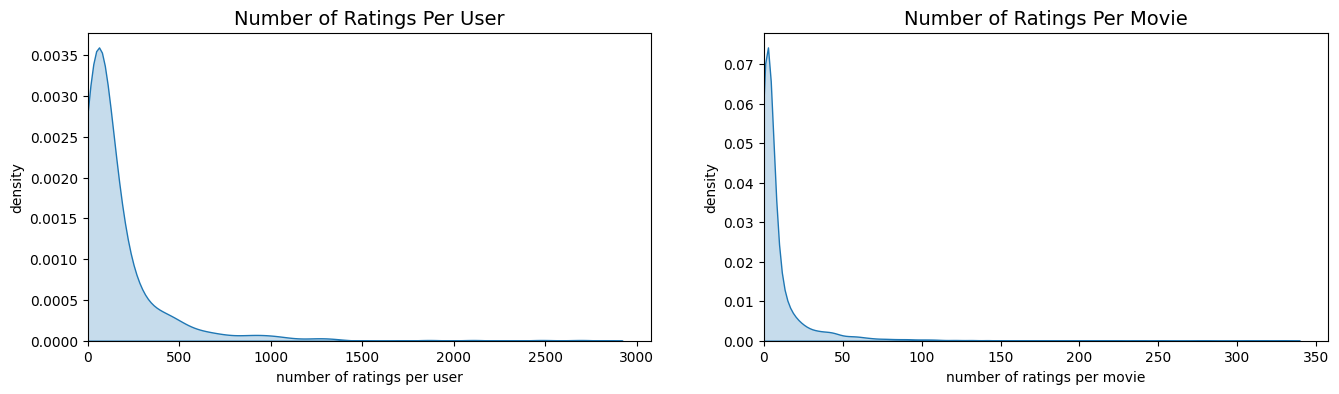

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

# **Step 5: Item-Item Recommendations with k-Nearest Neighbors**

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper,
                                     metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(f'   {movie_titles[i]}')

Because you watched Toy Story (1995):
   Toy Story 2 (1999)
   Jurassic Park (1993)
   Independence Day (a.k.a. ID4) (1996)
   Star Wars: Episode IV - A New Hope (1977)
   Forrest Gump (1994)
   Lion King, The (1994)
   Star Wars: Episode VI - Return of the Jedi (1983)
   Mission: Impossible (1996)
   Groundhog Day (1993)


In [ ]:
# Trying Euclidean metric
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper,
                                     metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(f'   {movie_titles[i]}')

Because you watched Toy Story (1995):
   Toy Story 2 (1999)
   Mission: Impossible (1996)
   Independence Day (a.k.a. ID4) (1996)
   Bug's Life, A (1998)
   Nutty Professor, The (1996)
   Willy Wonka & the Chocolate Factory (1971)
   Babe (1995)
   Groundhog Day (1993)
   Mask, The (1994)


In [ ]:
# Trying Manhattan metric
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper,
                                     metric='manhattan', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(f'   {movie_titles[i]}')

Because you watched Toy Story (1995):
   Toy Story 2 (1999)
   Bug's Life, A (1998)
   Groundhog Day (1993)
   Nutty Professor, The (1996)
   Willy Wonka & the Chocolate Factory (1971)
   Mission: Impossible (1996)
   Babe (1995)
   Monsters, Inc. (2001)
   Toy Story 3 (2010)


# **Step 6: Handling the Cold-Start Problems**

In [ ]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [ ]:
genres = set(g for G in movies['genres'] for g in G)
for g in genres:
    # print(g)
    movies[g] = movies.genres.transform(lambda x: int(g in x))

In [ ]:
movies.head(7)

,movieId,title,genres,Sci-Fi,(no genres listed),Mystery,Thriller,IMAX,Comedy,Crime,...,Children,Musical,Animation,Action,Western,Documentary,Film-Noir,Romance,War,Adventure
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),"[Action, Crime, Thriller]",0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6,7,Sabrina (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movie_genres = movies.drop(columns = ['movieId', 'title', 'genres'])
movie_genres.head(7)

,Sci-Fi,(no genres listed),Mystery,Thriller,IMAX,Comedy,Crime,Horror,Drama,Fantasy,Children,Musical,Animation,Action,Western,Documentary,Film-Noir,Romance,War,Adventure
0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [ ]:
print(cosine_sim)

[[1.         0.77459667 0.31622777 ... 0.         0.31622777 0.4472136 ]
 [0.77459667 1.         0.         ... 0.         0.         0.        ]
 [0.31622777 0.         1.         ... 0.         0.         0.70710678]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.31622777 0.         0.         ... 0.         1.         0.        ]
 [0.4472136  0.         0.70710678 ... 0.         0.         1.        ]]


## **Creating a movie finder function**

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = list(movies['title'])
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [ ]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
sim_scores = sim_scores[1: (n_recommendations+1)]
sim_scores

[(53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002)]

In [ ]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

In [ ]:
print(f"Because you watched {title}:")
for i in similar_movies:
    print(f'   {movies["title"][i]}')

Because you watched Jumanji (1995):
   Indian in the Cupboard, The (1995)
   NeverEnding Story III, The (1994)
   Escape to Witch Mountain (1975)
   Darby O'Gill and the Little People (1959)
   Return to Oz (1985)
   NeverEnding Story, The (1984)
   NeverEnding Story II: The Next Chapter, The (1990)
   Santa Claus: The Movie (1985)
   Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
   Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)


In [ ]:
# Putting all the above code in a single function

def get_content_based_recommendations(title_string, n_recommendations = 10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_score = list(enumerate(cosine_sim[idx]))
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse = True)
    sim_score = sim_score[1: (n_recommendations+1)]
    similar_movies = [i[0] for i in sim_score]
    print(f"Becuse you watched {title}:")
    for i in similar_movies:
        print(f'   {movies["title"][i]}')

In [ ]:
get_content_based_recommendations('jumanji')

Becuse you watched Jumanji (1995):
   Indian in the Cupboard, The (1995)
   NeverEnding Story III, The (1994)
   Escape to Witch Mountain (1975)
   Darby O'Gill and the Little People (1959)
   Return to Oz (1985)
   NeverEnding Story, The (1984)
   NeverEnding Story II: The Next Chapter, The (1990)
   Santa Claus: The Movie (1985)
   Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
   Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)


In [ ]:
get_content_based_recommendations('toy story', 5)

Becuse you watched Toy Story (1995):
   Antz (1998)
   Toy Story 2 (1999)
   Adventures of Rocky and Bullwinkle, The (2000)
   Emperor's New Groove, The (2000)
   Monsters, Inc. (2001)


# **Step 7: Dimensionality Reduction with Matrix Factorization**

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [ ]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper,
                                     metric='cosine', k=10)

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(f'   {movie_titles[i]}')

Because you watched Toy Story (1995):
   Home Alone (1990)
   Jurassic Park (1993)
   Aladdin (1992)
   Willy Wonka & the Chocolate Factory (1971)
   Back to the Future (1985)
   Groundhog Day (1993)
   Forrest Gump (1994)
   Star Wars: Episode IV - A New Hope (1977)
   Princess Bride, The (1987)


# **Some testing**

In [ ]:
get_content_based_recommendations('Avengers')

Becuse you watched Avengers, The (1998):
   Phantom, The (1996)
   Fled (1996)
   Ghost and the Darkness, The (1996)
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
   Indiana Jones and the Last Crusade (1989)
   Kull the Conqueror (1997)
   Tarzan and the Lost City (1998)
   Avengers, The (1998)
   Yojimbo (1961)
   Let's Get Harry (1986)


In [ ]:
get_content_based_recommendations('gandhi')

Becuse you watched Gandhi (1982):
   Othello (1995)
   Dangerous Minds (1995)
   Cry, the Beloved Country (1995)
   Restoration (1995)
   Georgia (1995)
   Home for the Holidays (1995)
   Mr. Holland's Opus (1995)
   Boys of St. Vincent, The (1992)
   Basketball Diaries, The (1995)
   Awfully Big Adventure, An (1995)


In [ ]:
get_content_based_recommendations('relic')

Becuse you watched Relic, The (1997):
   Tales from the Crypt Presents: Demon Knight (1995)
   In the Mouth of Madness (1995)
   Thinner (1996)
   Relic, The (1997)
   Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)
   Believers, The (1987)
   Birds, The (1963)
   Body Parts (1991)
   Candyman (1992)
   Nightmare on Elm Street, A (1984)


In [ ]:
get_content_based_recommendations('the dark knight',5)

Becuse you watched Dark Knight, The (2008):
   Need for Speed (2014)
   Fast Five (Fast and the Furious 5, The) (2011)
   Dead Presidents (1995)
   Bad Company (1995)
   Faster Pussycat! Kill! Kill! (1965)


In [ ]:
# trying a movie that doesn't exist in the movies file

get_content_based_recommendations('knives out')

# interpretation: gives the recommendation of a movie that is closest to the give movie title

Becuse you watched Grand Day Out with Wallace and Gromit, A (1989):
   Planet 51 (2009)
   Space Jam (1996)
   Chicken Little (2005)
   Meet the Robinsons (2007)
   Home (2015)
   Ratchet & Clank (2016)
   American Tail, An (1986)
   Bug's Life, A (1998)
   Transformers: The Movie (1986)
   Jimmy Neutron: Boy Genius (2001)


In [ ]:
get_content_based_recommendations('shutter island', 10)

Becuse you watched Shutter Island (2010):
   39 Steps, The (1935)
   Game, The (1997)
   The Devil's Advocate (1997)
   Insomnia (1997)
   Blue Velvet (1986)
   Lady Vanishes, The (1938)
   8MM (1999)
   Eyes Wide Shut (1999)
   Talented Mr. Ripley, The (1999)
   JFK (1991)
